# Automated Personalization Demystified

## Intuition for Foundational Machine Learning

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; } div.text_cell_render { font-family: 'Human BBY Office'; font-size: 12pt; line-height: 145%;}</style>"))
display(HTML("<style>.output_wrapper, .output { height:auto !important; max-height:1000px;}</style>"))

import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 300)

import sklearn as sk
from sklearn import model_selection

from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

def highlight_explanatory(s):
    return ['' if s.name == 'Type' or s.name == 'TypeShown' or s.name == 'Reward' or s.name == 'Weights' else 'background-color: #99ccff' for v in s]

table_styles = [
    dict(selector="th", props=[("font-size", "160%"), ("border-style", "solid"), ("text-align", "center")]),
    dict(selector="td", props=[("font-size", "160%"), ("border-style", "solid"), ("text-align", "center")]),
    dict(selector = "th:first-child", props = [('display', 'none')])
]

In [2]:
df = pd.read_csv('glass/glass.data', sep=",", header=None, encoding="ISO-8859-1")
df.columns = ['ID','RI','Na','Mg','Al','Si','K','Ca','Ba','Fe','Type']
y = df[['Type']]
X = df.drop(['ID', 'Type'], inplace=False, axis=1)
df.drop('ID', inplace=True, axis=1)
df.style.set_table_styles(table_styles).set_properties(**{'border-style': 'solid', 'font-size': '160%'}).apply(highlight_explanatory, axis=0)

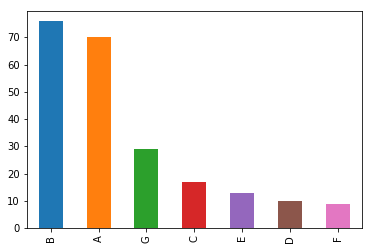

In [3]:
df['Type'].value_counts().plot(kind="bar")

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [5]:
decisionTreeRecipe = DecisionTreeClassifier(max_features = "auto", random_state=42)
decisionTreeRecipe.fit(X_train, y_train.values.ravel())
clf_score = decisionTreeRecipe.score(X_test, y_test.values.ravel())
print("Decision Tree recipe correct percentage: " + '{0:.1f}%'.format(clf_score * 100))

Decision Tree recipe correct percentage: 64.4%


In [6]:
kNeighborsRecipe = KNeighborsClassifier(n_neighbors=4)
kNeighborsRecipe.fit(X_train, y_train.values.ravel())
neigh_score = kNeighborsRecipe.score(X_test, y_test.values.ravel())
print("Nearest Neighbors recipe correct percentage: " + '{0:.1f}%'.format(neigh_score * 100))

Nearest Neighbors recipe correct percentage: 68.9%


In [7]:
gradientBoostRecipe = GradientBoostingClassifier()
gradientBoostRecipe.fit(X_train, y_train.values.ravel())
gbm_score = gradientBoostRecipe.score(X_train, y_train.values.ravel())
print("Gradient Boost recipe correct percentage: " + '{0:.1f}%'.format(gbm_score * 100))

Gradient Boost recipe correct percentage: 100.0%


In [8]:
# Try data with new inputs resembling Type F
X_random = np.array([[1.50,14.45,2.22,1.61,72.2,0.00,9.2,0.00,0.00]])
print("Decision Tree recipe predicts this data is from type: " + str(decisionTreeRecipe.predict(X_random)[0]))
print("Gradient Boost recipe predicts this data is from type: " + str(gradientBoostRecipe.predict(X_random)[0]))

Decision Tree recipe predicts this data is from type: C
Gradient Boost recipe predicts this data is from type: F


### Decision Tree recipe visualization

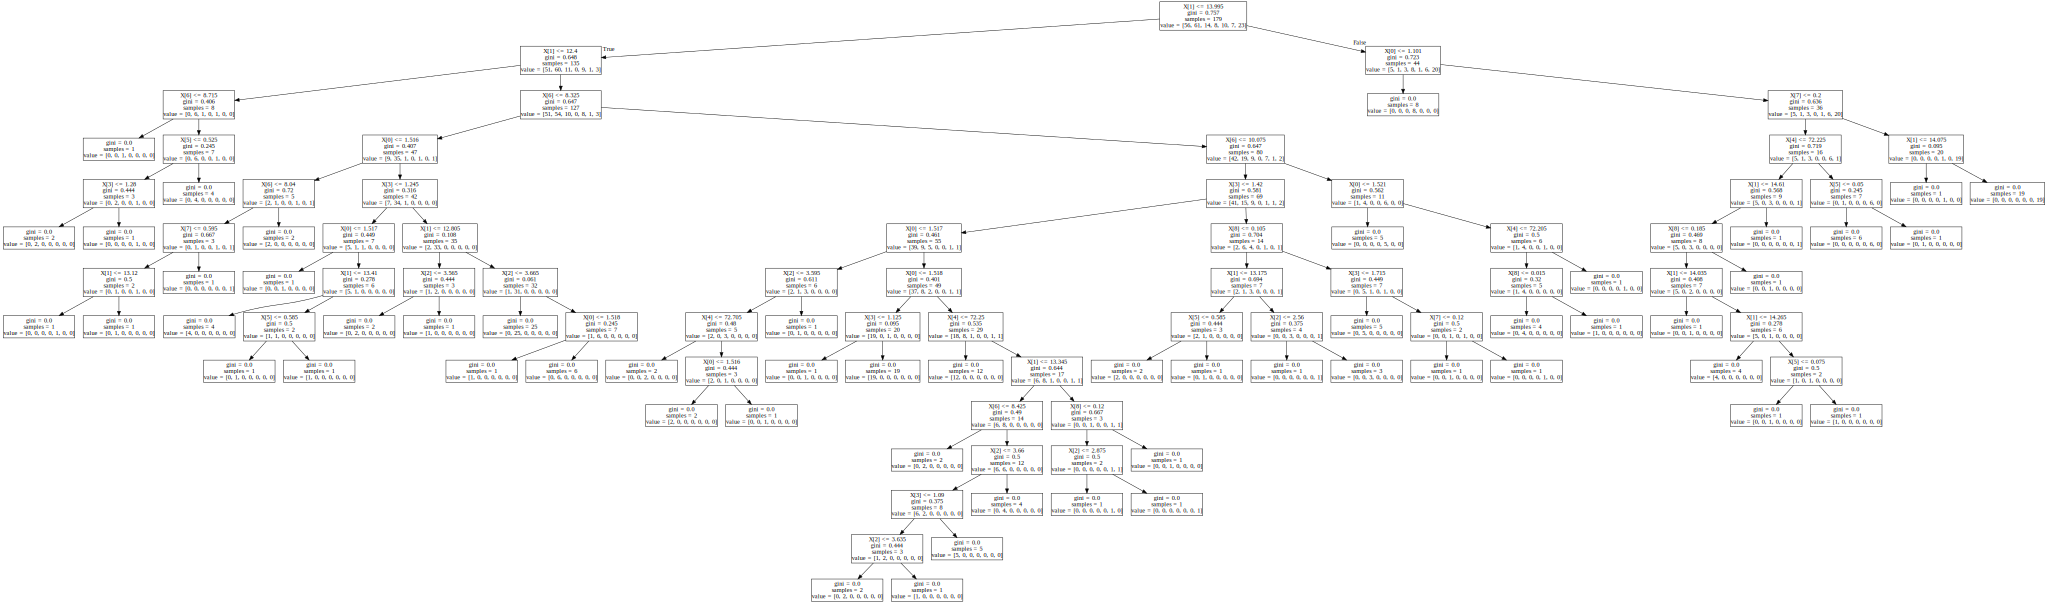

In [9]:
export_graphviz(decisionTreeRecipe, out_file="mytree.dot")
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

## Application of ML to Automated Personalization

### What would the data look like in an AP use case?

In [10]:
auto_df = pd.read_csv('glass/automatedPersonalization.data', sep=",", encoding="ISO-8859-1")
auto_df.drop(['ID','LikelihoodShown'], inplace=True, axis=1)
auto_df[['RI','Na','Mg','Al','Si','K','Ca','Ba','Fe','TypeShown','Reward']].style.set_table_styles(table_styles).set_properties(**{'border-style': 'solid', 'font-size': '160%'}).apply(highlight_explanatory, axis=0)

### Sampling from a skewed distribution

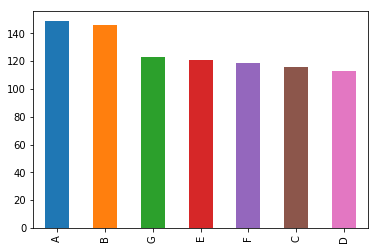

In [11]:
auto_df['TypeShown'].value_counts().plot(kind="bar")

### Using distribution skew to generate weights for each impression/trial

In [12]:
agg_percentages = auto_df.groupby('TypeShown').agg({'TypeShown': 'count'}).apply(lambda x: float(x.sum()) / x)
weights = agg_percentages['TypeShown'].to_dict()
weights

{'A': 5.953020134228188,
 'B': 6.075342465753424,
 'C': 7.646551724137931,
 'D': 7.849557522123894,
 'E': 7.330578512396694,
 'F': 7.453781512605042,
 'G': 7.211382113821138}

### Filter down to trials that won; add weights as a column

In [13]:
auto_df['Weights'] = auto_df.apply(lambda row: weights[row.TypeShown], axis=1)
reward_df = auto_df[auto_df.Reward == 1]
reward_df.style.set_table_styles(table_styles).set_properties(**{'border-style': 'solid', 'font-size': '160%'}).apply(highlight_explanatory, axis=0)

### Follow same methodology to produce a cost-sensitive recipe for making decisions

In [14]:
ry = reward_df[['TypeShown']]
rX = reward_df.drop(['Reward', 'TypeShown', 'Weights'], inplace=False, axis=1)
rX_train, rX_test, ry_train, ry_test = model_selection.train_test_split(rX, ry, test_size=0.2, stratify=ry, random_state=42)

In [15]:
costSensitiveClassifier = SVC(kernel='linear', class_weight=weights)
costSensitiveClassifier.fit(rX_train, ry_train.values.ravel())
clf_score = costSensitiveClassifier.score(rX_test, ry_test.values.ravel())
print("Cost Sensitive SV Classifier recipe correct percentage: " + '{0:.1f}%'.format(clf_score * 100))

Cost Sensitive SV Classifier recipe correct percentage: 53.6%


In [16]:
# Try data with inputs resembling Type F
print("Decision Tree recipe predicts this data should be assigned to Type: " + str(costSensitiveClassifier.predict(X_random)[0]))

Decision Tree recipe predicts this data should be assigned to Type: F
